In [341]:
# MLflow
import mlflow
from mlflow.models import infer_signature

# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualizations
import matplotlib.pyplot as plt

# math functions
import numpy as np

# read CSV file
import os
import glob

# data frames
import pandas as pd

# regexes
import re

# Print pandas.describe() in PDF
from prettytable import PrettyTable

# converting created dates from reddit API into human readable format
from datetime import datetime, timedelta

In [342]:
# Disable automated output
import warnings
# Future deprecation warnings
warnings.filterwarnings("ignore")
import logging
# Set logging level to suppress INFO messages
logging.getLogger('mlflow').setLevel(logging.WARNING)

# set default logging level
logging.basicConfig(level=logging.INFO)  # Set the root logger level to DEBUG
# Create a logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# Create a StreamHandler to output logs to the console
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)
# Create a formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# Set the formatter for the handler
console_handler.setFormatter(formatter)
# Add the console handler to the logger
logger.addHandler(console_handler)

In [343]:
# https://medium.com/bitgrit-data-science-publication/sentiment-analysis-on-reddit-tech-news-with-python-cbaddb8e9bb6

# Load NLTK Libraries

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# Downloading NLTK's databases
nltk.download('vader_lexicon', quiet=True); # get lexicons data
nltk.download('punkt', quiet=True); # for tokenizer
nltk.download('stopwords', quiet=True); # dictionary for tokenization


In [344]:
# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-02-25 15:54:18,672 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-02-25 15:54:18,672 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-02-25 15:54:18,672 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-02-25 15:54:18,672 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-02-25 15:54:18,672 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-02-25 15:54:18,672 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-02-25 15:54:18,672 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-0

In [345]:
import zipfile

# Make dir if it does not exist, then write csv to file in dir, return the directory
def df_to_csv(df, dir, file):
    if isinstance(dir, list):
        dir = '/'.join(dir)
    csv = '/'.join([dir, 'raw', file])
    zip = '/'.join([dir, 'zip', file + '.zip'])
    for file in [csv, zip]:
        folder = os.path.dirname(file)
        if not os.path.exists(folder):
            os.makedirs(folder)
    df.to_csv(csv)
    # Create a zip file and add the input CSV file to it
    with zipfile.ZipFile(zip, 'w', compression=zipfile.ZIP_DEFLATED, compresslevel=9) as zipf:
        zipf.write(csv, os.path.basename(csv))
    
    return dir

# Default directory for this file output
output_dir = ['output', 'sentiment-analysis']

# Reddit Subreddit API analysis

Subreddit Stats
+-------+----------------------+-------------+----------------------+-----------------+
| index |         name         | subscribers |     display_name     | subscribers_pct |
+-------+----------------------+-------------+----------------------+-----------------+
|   1   |       chatgpt        |   4505500   |       chatgpt        |      36.55      |
|   10  |   machinelearning    |   2870456   |   MachineLearning    |      23.28      |
|   4   |     datascience      |   1366348   |     datascience      |      11.08      |
|   11  |        openai        |   1124730   |        OpenAI        |       9.12      |
|   7   |         gpt3         |    722076   |         GPT3         |       5.86      |
|   0   |      artificial      |    720095   |      artificial      |       5.84      |
|   9   | learnmachinelearning |    384514   | learnmachinelearning |       3.12      |
|   3   | chatgptpromptgenius  |    193280   | ChatGPTPromptGenius  |       1.57      |
|   5   |       

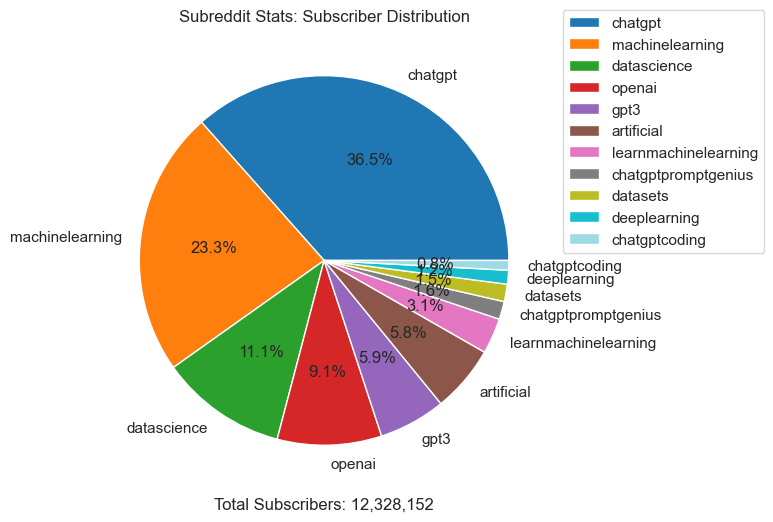

In [346]:
# Reddit metadata structure
subreddit_dict = {  "name":[],
                    "subscribers":[] }

# Import subreddit metadata
metadata = pd.DataFrame()
for fname in glob.iglob(os.path.abspath('./data/**/*.meta'), recursive=True):
    _metadata = pd.read_csv(fname)
    # Drop the column 'Unnamed: 0'
    _metadata.drop(columns=['Unnamed: 0'], inplace=True)
    _metadata['display_name'] = _metadata['name']
    _metadata['name'] = _metadata['name'].str.lower()
    metadata = metadata.append(_metadata.copy(), ignore_index=True)
    #print(fname)
    #break #DEBUG

# Drop duplicates from the 'name' column
metadata.reset_index(inplace=True)  # Reset index
metadata.drop_duplicates(subset='name', inplace=True)  # Drop duplicates based on the 'name' column
metadata.sort_values(by='subscribers', ascending=False, inplace=True)

# filter subreddits with less than 100,000 subscribers
metadata = metadata[metadata['subscribers'] > 100000]
# Calculate subscribers as a percentage of the total
total_subscribers = metadata['subscribers'].sum()
metadata['subscribers_pct'] = (metadata['subscribers'] / total_subscribers) * 100

print('Subreddit Stats')
# Create a PrettyTable object
table = PrettyTable()
# Add columns to the table
table.field_names = metadata.columns
# Add rows to the table
for row in metadata.itertuples(index=False):
    # Set the float format for all float columns
    float_format = "{:.2f}"
    # Format float values
    row = [float_format.format(value) if isinstance(value, float) else value for value in row]
    table.add_row(row)
# Print the table
print(table)

# After printing, set name as the index
metadata.set_index('name', inplace=True)  # Set the 'name' column as the index of the DataFrame

# Write output file
df_to_csv(metadata, output_dir, 'subreddits.meta')

# Plot pie chart of sentiment label distribution
plt.figure(figsize=(8, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(metadata)))
metadata['subscribers_pct'].plot(kind='pie', autopct='%1.1f%%', colors=colors)
# Add annotations for subscriber percentages
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.title('Subreddit Stats: Subscriber Distribution')
plt.ylabel('')
plt.xlabel('Total Subscribers: ' + "{:,}".format(total_subscribers))
plt.show()

# Reddit Search API data analysis

In [347]:
# Reddit posts data structure
posts_dict_template = {"id":[],
                        "subreddit":[],
                        "query":[],
                        "sort":[],
                        "date":[],
                        "title":[],
                        "author":[],
                        "stickied":[],
                        "upvote_ratio":[],
                        "score":[],
                        "url":[],
                        "num_comments": [],
                        "created": [],
                        "body":[]}

# Import query data
df_posts = pd.DataFrame()
running_total = 0
for fname in glob.glob(os.path.abspath('./data/**/posts.csv'), recursive=True):
    _df=pd.read_csv(fname)

    # Check for empty dataset
    if _df.empty: continue
    # Drop the column 'Unnamed: 0'
    _df.drop(columns=['Unnamed: 0'], inplace=True)
    _df['subreddit'] = _df[_df['subreddit'].str.lower().isin(metadata.index)]['subreddit'].str.lower()
    # Remove missing subreddit values
    _df = _df[_df['subreddit'].notna()]
    if _df.empty: continue

    # Append the dataset with calculated columns to the complete dataset
    _df['date'] = pd.to_datetime(_df['date']) # convert date column
    df_posts = pd.concat([df_posts, _df], ignore_index=True)
    running_total+=len(_df)
    #print(fname)
    #print(running_total)
    #break #DEBUG

# remove duplicate posts
df_posts.reset_index(inplace=True)  # Reset index
df_posts.drop_duplicates(subset='id', inplace=True)  # Drop duplicates based on the 'id' column
df_posts.set_index('id', inplace=True)  # Set the 'id' column as the index of the DataFrame

# Output data to CSV
df_to_csv(df_posts, output_dir, 'posts.csv')

print(f"Total imported Reddit posts: {running_total}")
print(f"Duplicate cross-subreddit posts: {running_total-len(df_posts)}")
print(f"De-duplicated reddit posts: {len(df_posts)}")

Total imported Reddit posts: 9822
Duplicate cross-subreddit posts: 7345
De-duplicated reddit posts: 2477


# Reddit Comment API data analysis

In [348]:
# Reddit comments data structure
comments_dict_template = {"id":[],
                        "comment_id":[],
                        "comment_date":[],
                        "comment_score":[],
                        "comment_num_replies":[],
                        "comment_body":[]}

# Import query data
df_comments = pd.DataFrame()
running_total = 0
for fname in glob.glob(os.path.abspath('./data/**/comments.csv'), recursive=True):
    _df=pd.read_csv(fname)

    # Check for empty dataset
    if _df.empty: continue
    # Drop the column 'Unnamed: 0'
    _df.drop(columns=['Unnamed: 0'], inplace=True)

    # Add subreddit value and drop missing subreddits
    _df['subreddit'] = _df['id'].map(df_posts['subreddit'])
    _df.dropna(subset=['subreddit'], inplace=True)

    # Append the dataset with calculated columns to the complete dataset
    _df['comment_date'] = pd.to_datetime(_df['comment_date']) # convert date column
    df_comments = pd.concat([df_comments, _df], ignore_index=True)
    running_total+=len(_df)
    #print(fname)
    #print(running_total)
    #break #DEBUG


# remove duplicate posts
df_comments.reset_index(inplace=True)  # Reset index
df_comments.drop_duplicates(subset=['id', 'comment_id'], inplace=True)  # Drop duplicates based on the 'id' column
df_comments.set_index(['id', 'comment_id'], inplace=True)  # Set the 'id' column as the index of the DataFrame

# Output data to CSV
df_to_csv(df_comments, output_dir, 'comments.csv')

'output/sentiment-analysis'

# Sentiment analysis

In [349]:
#Create a function to clean the tweets
def cleanTxt(text):
    text = re.sub(r'@[A-Za-z0–9]+', '', text) #Remove @mentions replace with blank
    text = re.sub(r'#', '', text) #Remove the ‘#’ symbol, replace with blank
    text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
    text = re.sub(r':', '', text) # Remove :
    return text

#Next we have to remove emoji & Unicode from the Tweet data.
def remove_emoji(string):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F" # emoticons
    u"\U0001F300-\U0001F5FF" # symbols & pictographs
    u"\U0001F680-\U0001F6FF" # transport & map symbols
    u"\U0001F1E0-\U0001F1FF" # flags (iOS)
    u"\U00002500-\U00002BEF" # chinese char
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642"
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f" # dingbats
    u"\u3030"
    "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [350]:
def vader_sentiment(dataset, column):
    # VADER sentiment analysis
    sid = SentimentIntensityAnalyzer()

    clean = column + '_clean'
    neg = column + '_neg'
    neu = column + '_neu'
    pos = column + '_pos'
    compound = column + '_compound'
    label = column + '_sentiment'

    dataset[clean] = dataset[column].apply(lambda x: remove_emoji(cleanTxt(x)) if pd.notna(x) else '')

    # VADER analysis
    dataset[[neg, neu, pos, compound]] = dataset[clean].apply(lambda text: pd.Series(sid.polarity_scores(text)))

    # Threshold conditions determine the value of the sentiment of the text
    THRESHOLD = 0.2
    conditions = [
        (dataset[compound] <= -THRESHOLD),
        (dataset[compound] > -THRESHOLD) & (dataset[compound] < THRESHOLD),
        (dataset[compound] >= THRESHOLD),
        ]
    values = ["neg", "neu", "pos"]
    dataset[label] = np.select(conditions, values)

    # Convert all sentiment columns to numeric type
    dataset[[neg, neu, pos, compound]] = dataset[[neg, neu, pos, compound]].apply(pd.to_numeric, errors='coerce')


In [351]:
# Prepare dataset by combining title and body
df_posts['text'] = df_posts.apply(lambda row: row['title'] + '. ' + row['body'] if pd.notna(row['body']) else row['title'], axis=1)

# apply vader sentiment to matched datasets
vader_sentiment(df_posts, 'text')
vader_sentiment(df_comments, 'comment_body')

In [ ]:
df_posts.head(2)

,index,subreddit,query,sort,date,title,author,stickied,upvote_ratio,score,...,num_comments,created,body,text,text_clean,text_neg,text_neu,text_pos,text_compound,text_sentiment
id,,,,,,,,,,,,,,,,,,,,,
12brxc1,0,artificial,ChatGPT,top,2023-04-04 18:29:49,Rap battle between ChatGPT and Google Bard,seasick__crocodile,0.0,0.97,772.0,...,158.0,1.680633e+09,"Aside from each program’s first turn, both wer...",Rap battle between ChatGPT and Google Bard. As...,Rap battle between ChatGPT and Google Bard. As...,0.071,0.929,0.000,-0.3818,neg
zycjcl,1,artificial,ChatGPT,top,2022-12-29 18:33:34,ChatGPT's Gender Sensitivity: Is It Joking Abo...,bratwurstgeraet,0.0,0.89,510.0,...,72.0,1.672339e+09,"Hey Redditors,\n\nI just had a really interest...",ChatGPT's Gender Sensitivity: Is It Joking Abo...,ChatGPT's Gender Sensitivity Is It Joking Abou...,0.054,0.763,0.182,0.9883,pos


# Data preparation

In [ ]:
def apply_subreddit_weight(dataset, column, inplace=True):
    if inplace: _dataset = dataset
    else: _dataset = dataset.copy()
    column_weight = column + '_weighted'
    # Calculate weighted score by dividing the score by the percentage of the subreddit
    _dataset[column_weight] = _dataset.apply(
        lambda row: row[column] * 100 / (100 - metadata.loc[row['subreddit']]['subscribers_pct']), axis=1)
    return _dataset

apply_subreddit_weight(df_posts, 'score')
apply_subreddit_weight(df_posts, 'num_comments')
apply_subreddit_weight(df_comments, 'comment_score')
apply_subreddit_weight(df_comments, 'comment_num_replies')

# Merge posts with comments
df = pd.merge(df_posts, df_comments, on='id', how='left')

# Output data analysis to CSV
df_to_csv(df, output_dir, 'combined.csv')

'output/sentiment-analysis'

# Dataset split on launch dates

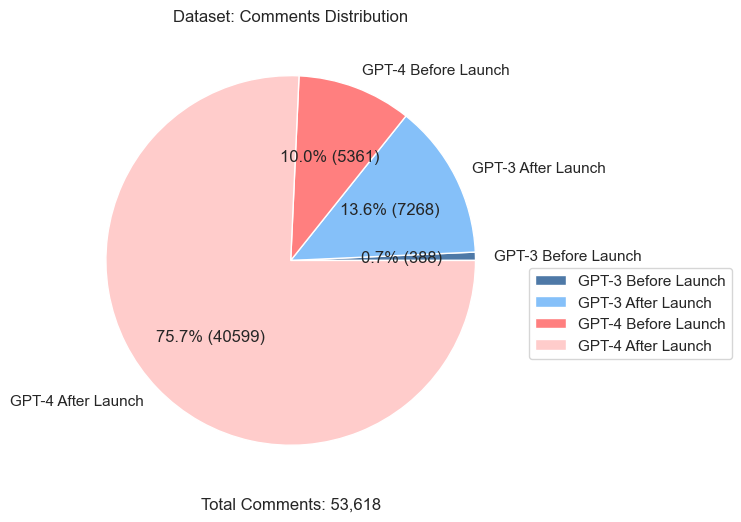

In [ ]:
# Define the date range for GPT-3 hype analysis
gpt3_start = datetime(2022, 11, 1)
gpt3_launch = datetime(2022, 11, 30)
gpt3_end = datetime(2023, 1, 31)

# Define the date range for GPT-4 hype analysis
gpt4_start = datetime(2023, 2, 15)
gpt4_launch =  datetime(2023, 3, 14)
gpt4_end = datetime(2023, 5, 15)

# Filter GPT-3 dataset
df_gpt3 = df[(gpt3_start <= df['date']) & (df['date'] < gpt3_end + timedelta(days=1))]
df_gpt3 = df[(gpt3_start <= df['comment_date']) & (df['comment_date'] < gpt3_end + timedelta(days=1))]
# get the distance of the date to the GPT-3 launch date
df_gpt3['launch_distance'] = abs(gpt3_launch - df_gpt3['date'])
df_gpt3['launch_distance_f'] = df_gpt3['launch_distance'] / pd.to_timedelta(1, unit='D')


# Filter GPT-4 dataset
df_gpt4 = df[(gpt4_start <= df['date']) & (df['date'] < gpt4_end + timedelta(days=1))]
df_gpt4 = df[(gpt4_start <= df['comment_date']) & (df['comment_date'] < gpt4_end + timedelta(days=1))]
# get the distance of the date to the GPT-4 launch date
df_gpt4['launch_distance'] = abs(gpt4_launch - df_gpt4['date'])
df_gpt4['launch_distance_f'] = df_gpt4['launch_distance'] / pd.to_timedelta(1, unit='D')

# Split at gpt3_launch date
df_gpt3_before = df_gpt3[df_gpt3['date'] < gpt3_launch]
df_gpt3_after = df_gpt3[gpt3_launch <= df_gpt3['date']]
# Split at gpt4_launch date
df_gpt4_before = df_gpt4[df_gpt4['date'] < gpt4_launch]
df_gpt4_after = df_gpt4[gpt4_launch <= df_gpt4['date']]

# Get counts of datasets before and after launch dates
df_gpt_counts = {
    'GPT-3 Before Launch': len(df_gpt3_before),
    'GPT-3 After Launch': len(df_gpt3_after),
    'GPT-4 Before Launch': len(df_gpt4_before),
    'GPT-4 After Launch': len(df_gpt4_after)
}
# Plot pie chart of GPT search distribution
plt.figure(figsize=(8, 6))
colors = ['#4e79a7', '#85c0f9', '#ff7f7f', '#ffcccb']  
plt.pie(df_gpt_counts.values(), colors=colors, labels=df_gpt_counts.keys(), autopct=lambda pct: f"{pct:.1f}% ({int(pct/100*sum(df_gpt_counts.values()))})")
# Add annotations for subscriber percentages
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.title('Dataset: Comments Distribution')
plt.ylabel('')
plt.xlabel('Total Comments: ' + "{:,}".format(sum(df_gpt_counts.values())))
plt.show()

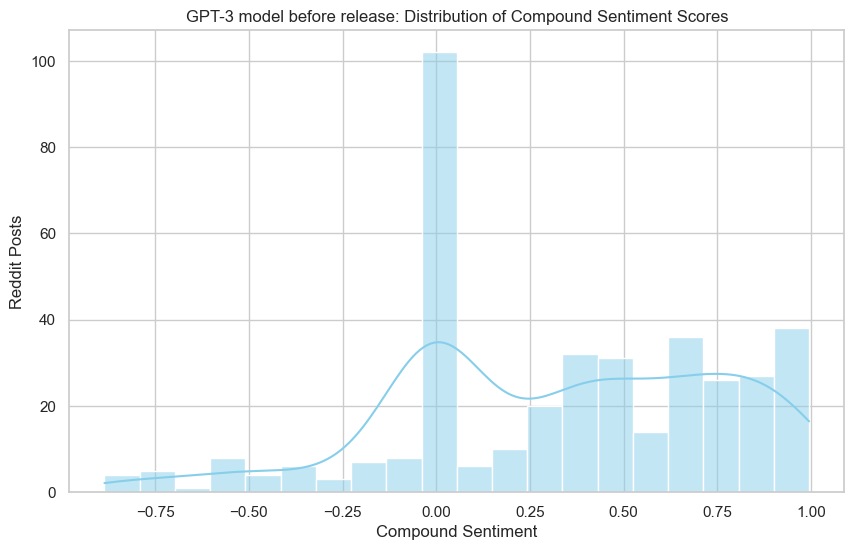

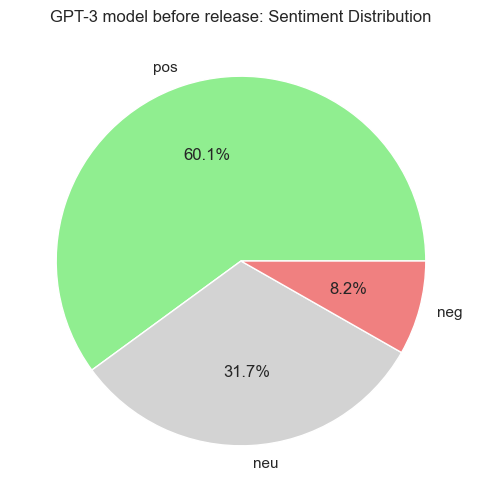

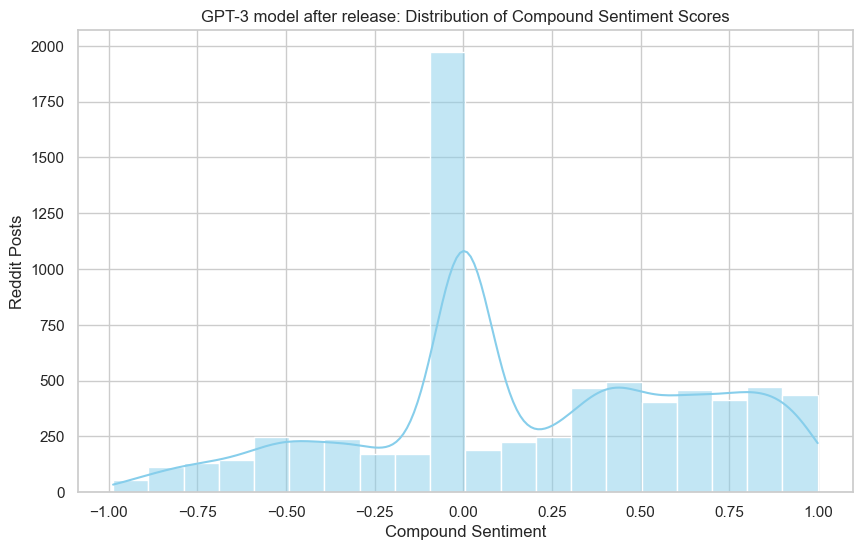

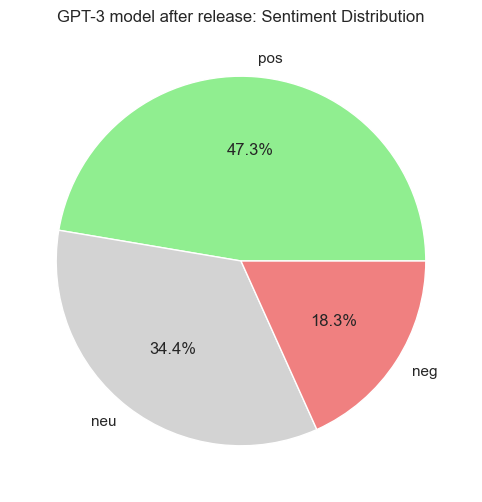

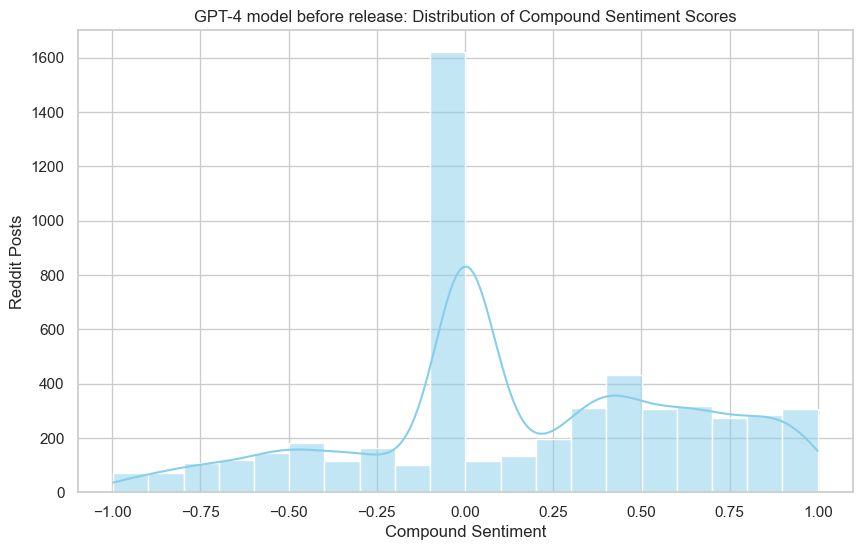

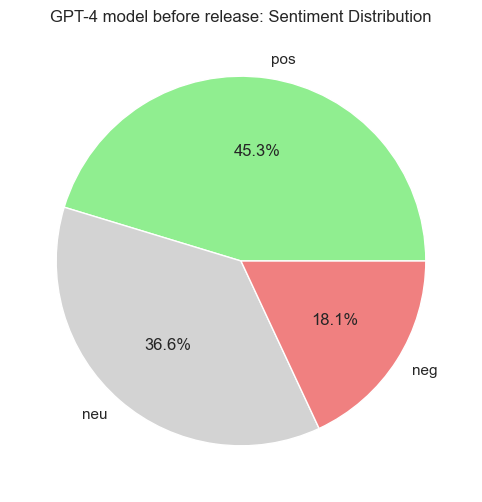

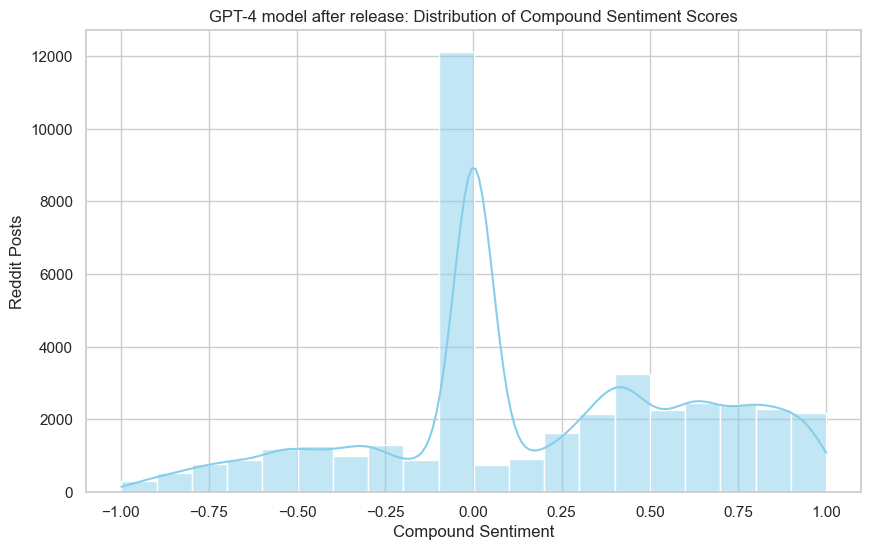

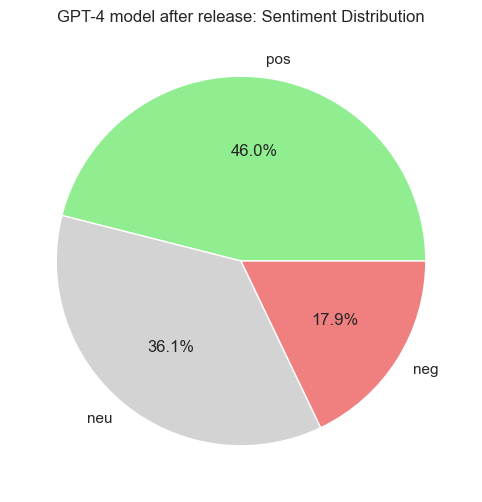

In [ ]:
def visualize_sentiment(dataset, name):
    # Plot histogram of compound sentiment scores
    plt.figure(figsize=(10, 6))
    sns.histplot(data=dataset, x='comment_body_compound', bins=20, kde=True, color='skyblue')
    plt.title(name + ': Distribution of Compound Sentiment Scores')
    plt.xlabel('Compound Sentiment')
    plt.ylabel('Reddit Posts')
    plt.show()

    # Plot pie chart of sentiment label distribution
    plt.figure(figsize=(8, 6))
    dataset['comment_body_sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightgray', 'lightcoral'])
    plt.title(name + ': Sentiment Distribution')
    plt.ylabel('')
    plt.show()
visualize_sentiment(dataset=df_gpt3_before, name='GPT-3 model before release')
visualize_sentiment(dataset=df_gpt3_after, name='GPT-3 model after release')
visualize_sentiment(dataset=df_gpt4_before, name='GPT-4 model before release')
visualize_sentiment(dataset=df_gpt4_after, name='GPT-4 model after release')

# Preparing MLflow features and targets

In [ ]:
# Features to measure with MLflow
feature_names = ['launch_distance_f', 'num_comments_weighted', 'stickied', 'upvote_ratio', 'created',
                 'text_compound', 'text_pos', 'text_neg', 'text_neu']
# Target MLflow value
target_name = 'score_weighted'
# these variables should be represented as log of the original values
log_variables = ['score_weighted','num_comments', 'launch_distance_f', 'num_comments_weighted']

def clean_dataset(dataset, csv_name, inplace=True):
    global log_variables, feature_names, target_name
    if inplace is True:
        _dataset = dataset
    else:
        _dataset = dataset.copy()
    for variable in log_variables:
        # Rename the variables to log_[variable] in the datasets
        log_variable = 'log_'+variable
        if target_name == variable:
            target_name = log_variable
        elif variable in feature_names:
            feature_names[feature_names.index(variable)] = log_variable
        _dataset[log_variable] = _dataset[variable].apply(lambda value: np.log(value+1))
    _dataset.dropna(subset=feature_names, how="any", inplace=inplace)
    _dataset.dropna(subset=target_name, how="any", inplace=inplace)
    _dataset = _dataset.sort_index()
    
    ## Output file to csv
    df_to_csv(_dataset, output_dir, csv_name + '.csv')
    return _dataset

clean_dataset(df_gpt3_before, 'gpt3-before')
clean_dataset(df_gpt3_after, 'gpt3-after')
clean_dataset(df_gpt4_before, 'gpt4-before')
clean_dataset(df_gpt4_after, 'gpt4-after')

# These features are disabled. Stickied items throw off the counts.
for feature in ['stickied', 'created', 'text_pos', 'text_neg', 'text_neu']: feature_names.remove(feature)

print(f"feature_names={feature_names}")
print(f"target_name={target_name}")

feature_names=['log_launch_distance_f', 'log_num_comments_weighted', 'upvote_ratio', 'text_compound']
target_name=log_score_weighted


In [ ]:
def describe_dataset(dataset, name):
    print(name)
    description_table = dataset.describe()

    # Convert the 'created' column to datetime
    description_table['created'] = pd.to_datetime(description_table['created'], unit='s')

    description_table = description_table.transpose()
    description_table.reset_index(inplace=True)

    # Create a PrettyTable object for the first half of columns
    table1 = PrettyTable()
    table1.field_names = description_table.columns[:1+len(description_table.columns)//2]

    # Create a PrettyTable object for the second half of columns, including the first column
    table2 = PrettyTable()
    table2.field_names = ['index'] + list(description_table.columns[1+len(description_table.columns)//2:])

    # Set the float format for all float columns
    float_format = "{:.2f}"

    # Set the timedelta format
    def format_timedelta(td):
        days = td.days
        hours, remainder = divmod(td.seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return f"{days} days" # {hours:02}:{minutes:02}:{seconds:02}
    
    # Format date
    def format_date(dt):
        return dt.strftime("%Y-%m-%d") # %H:%M:%S

    # Add rows to the tables
    for row in description_table.itertuples(index=False):
        # Convert timedelta values to formatted strings
        row = list(row)
        for i, value in enumerate(row):
            if isinstance(value, pd.Timedelta):
                row[i] = format_timedelta(value)
            elif isinstance(value, pd.Timestamp):
                row[i] = format_date(value)
        # Format float values
        row = [float_format.format(value) if isinstance(value, float) else value for value in row]
        # Add row to the first table
        table1.add_row(row[:1+len(description_table.columns)//2])
        # Add row to the second table
        table2.add_row([row[0]] + row[1+len(description_table.columns)//2:])

    # Print the tables
    print(table1)
    print(table2)

describe_dataset(dataset=df_gpt3_before, name='GPT-3 model before release')
describe_dataset(dataset=df_gpt3_after, name='GPT-3 model after release')
describe_dataset(dataset=df_gpt4_before, name='GPT-4 model before release')
describe_dataset(dataset=df_gpt4_after, name='GPT-4 model after release')

GPT-3 model before release
+------------------------------+------------+------------+------------+------------+
|            index             |   count    |    mean    |    std     |    min     |
+------------------------------+------------+------------+------------+------------+
|           index_x            |   388.00   |  1684.08   |   529.89   |   134.00   |
|           stickied           |   388.00   |    0.00    |    0.00    |    0.00    |
|         upvote_ratio         |   388.00   |    0.91    |    0.11    |    0.43    |
|            score             |   388.00   |   193.27   |   162.69   |    0.00    |
|         num_comments         |   388.00   |   78.54    |   76.98    |    1.00    |
|           created            | 1970-01-01 | 2022-11-13 | 1970-01-08 | 2022-11-01 |
|           text_neg           |   388.00   |    0.02    |    0.04    |    0.00    |
|           text_neu           |   388.00   |    0.84    |    0.10    |    0.41    |
|           text_pos           |   388

# Run MLflow experiment
Linear regression analysis. Remove "stickied" Reddit posts from data.

Test model against data after GPT-4 launch.

In [ ]:
# Enable automatic logging to MLflow
mlflow.set_experiment("Reddit GPT Hype")
mlflow.autolog()

def trim_dataset(dataset, q_lower = .1, q_upper = .9):
    global target_name
    quantile = target_name
    _dataset = dataset.copy()
    # Trim dataset by the quantile for the target for training
    _dataset = _dataset[(_dataset['stickied'] == False)]
    _q_lower = _dataset[quantile].quantile(q_lower)
    _q_upper = _dataset[quantile].quantile(q_upper)
    _dataset = _dataset[(_dataset[quantile] >= _q_lower) &
                        (_dataset[quantile] <= _q_upper)]
    return _dataset

def model_testing(dataset, test):
    _dataset = dataset.copy()
    _test = test.copy()
    # Trim upper and lower quantiles
    _dataset = trim_dataset(_dataset)
    _test = trim_dataset(_test)
    # Sort values for displaying in graph
    _dataset = dataset
    _test = _test
    # Set X features and y targets
    X_test = _test.loc[:, _test.columns[:,None] == feature_names]
    y_test = _test.loc[:, _test.columns == target_name].values
    X = _dataset.loc[:, _dataset.columns[:,None] == feature_names]
    y = _dataset.loc[:, _dataset.columns == target_name].values

    lr_params =  {}
    lr = LinearRegression(**lr_params)

    # MLflow triggers logging automatically upon model fitting
    lr.fit(X, y)
    y_pred = lr.predict(X_test)

    return {'X': X, 'y': y, 'X_test': X_test, 'y_actual': y_test, 'y_pred': y_pred, 'coef': lr.coef_}

gpt3_model = model_testing(df_gpt3_before, df_gpt3_after)
gpt4_model = model_testing(df_gpt4_before, df_gpt4_after)

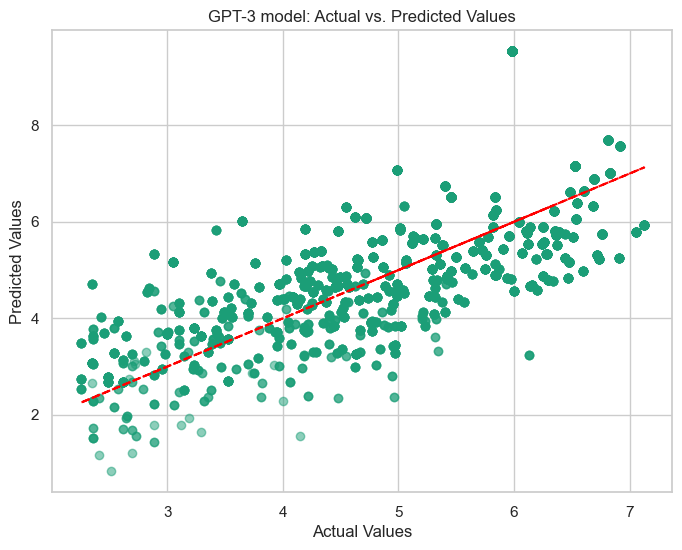

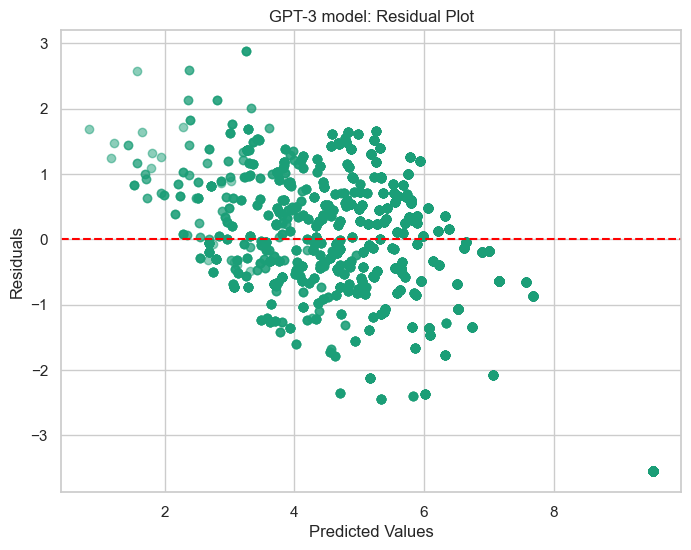

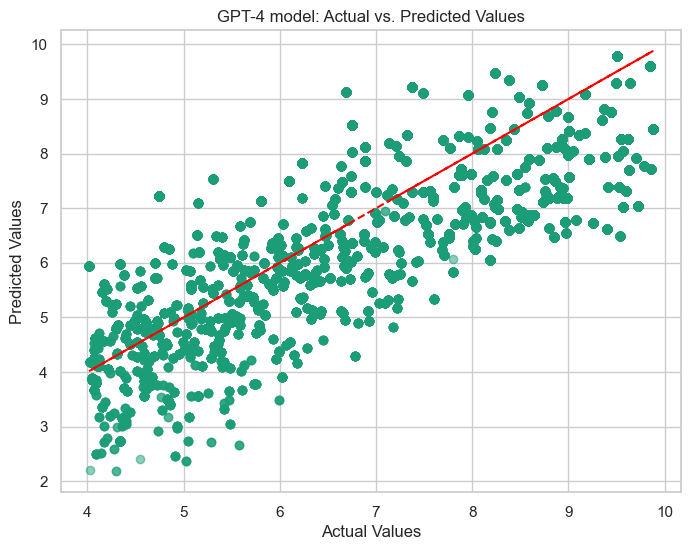

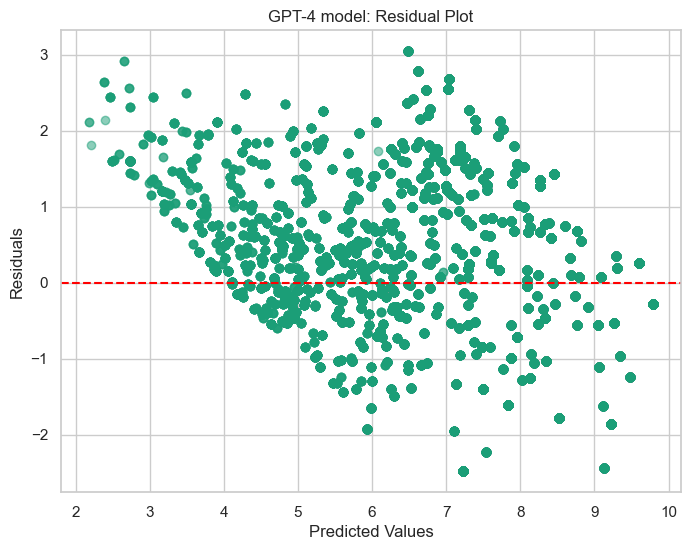

In [ ]:
# Plot accuracy of the models
def plot_accuracy(model, name):
    actual_values = model['y_actual']
    predicted_values = model['y_pred']

    # Scatter plot of actual versus predicted values
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_values, predicted_values, alpha=0.5)
    plt.plot(actual_values, actual_values, color='red', linestyle='--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(name + ": Actual vs. Predicted Values")
    plt.grid(True)
    plt.show()

    # Residual plot
    residuals = actual_values - predicted_values
    plt.figure(figsize=(8, 6))
    plt.scatter(predicted_values, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(name + ": Residual Plot")
    plt.grid(True)
    plt.show()

    # Coefficient plot (if coefficients are available in the MLflow run)
    if "coefficients" in model:
        coefficients = model["coef"]
        plt.figure(figsize=(8, 6))
        sns.barplot(x=coefficients.index, y=coefficients.values)
        plt.xlabel("Independent Variables")
        plt.ylabel("Coefficients")
        plt.title("Coefficient Plot")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
plot_accuracy(model=gpt3_model, name='GPT-3 model')
plot_accuracy(model=gpt4_model, name='GPT-4 model')

# Feature Plots

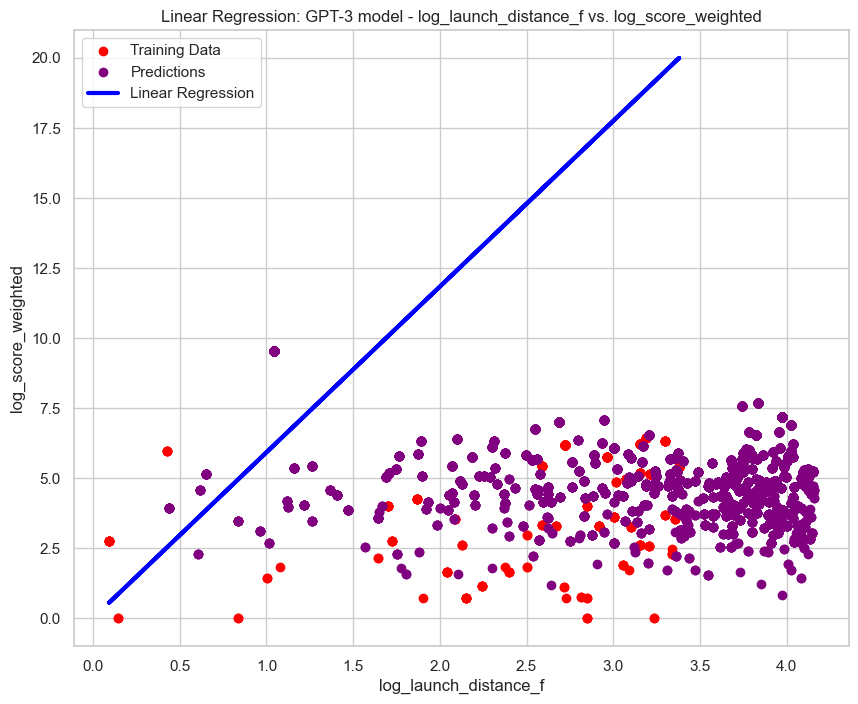

log_launch_distance_f=5.912016895310219


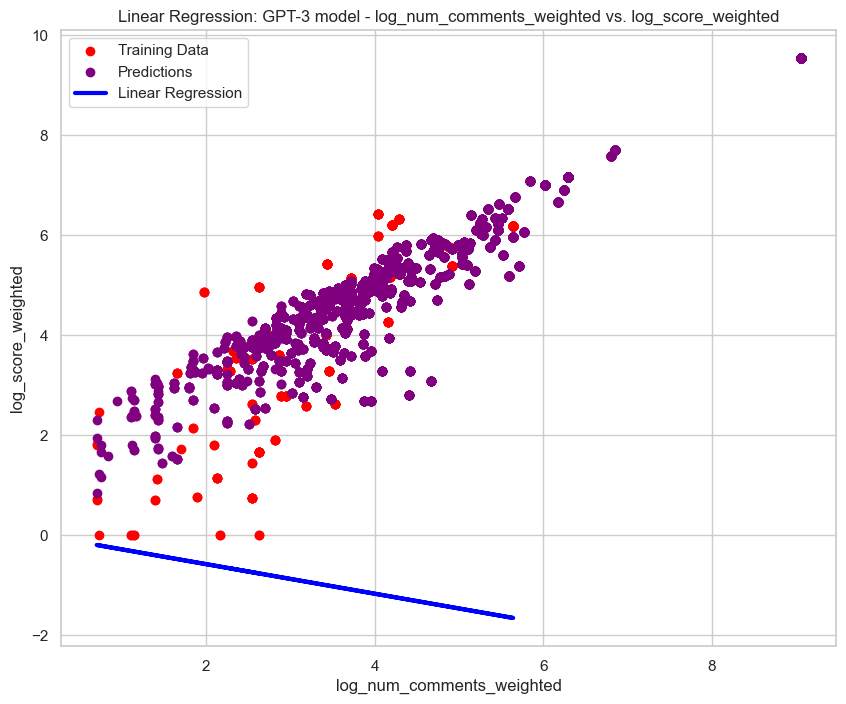

log_num_comments_weighted=-0.2952811609381052


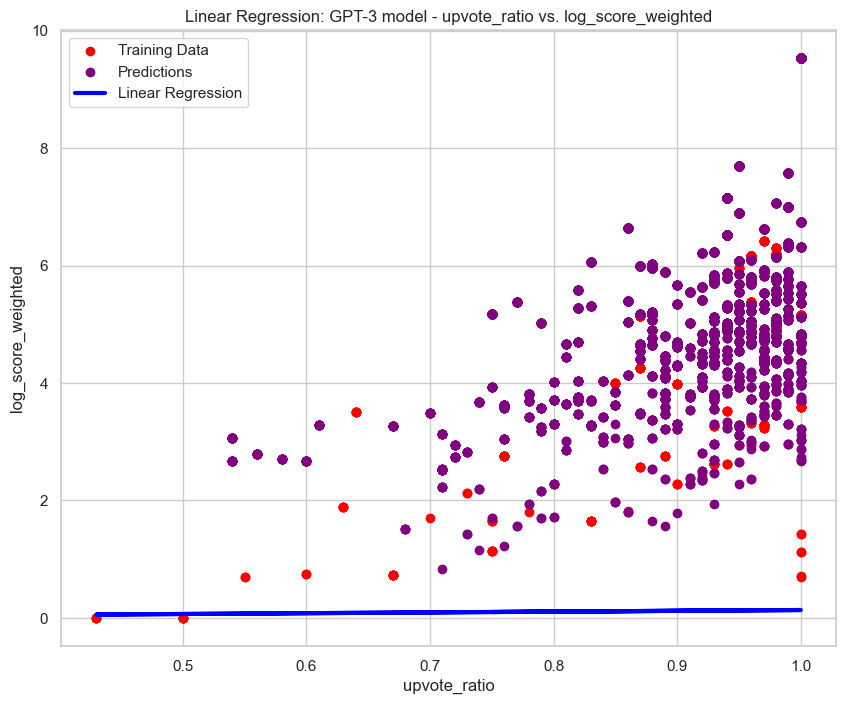

upvote_ratio=0.13521419146443686


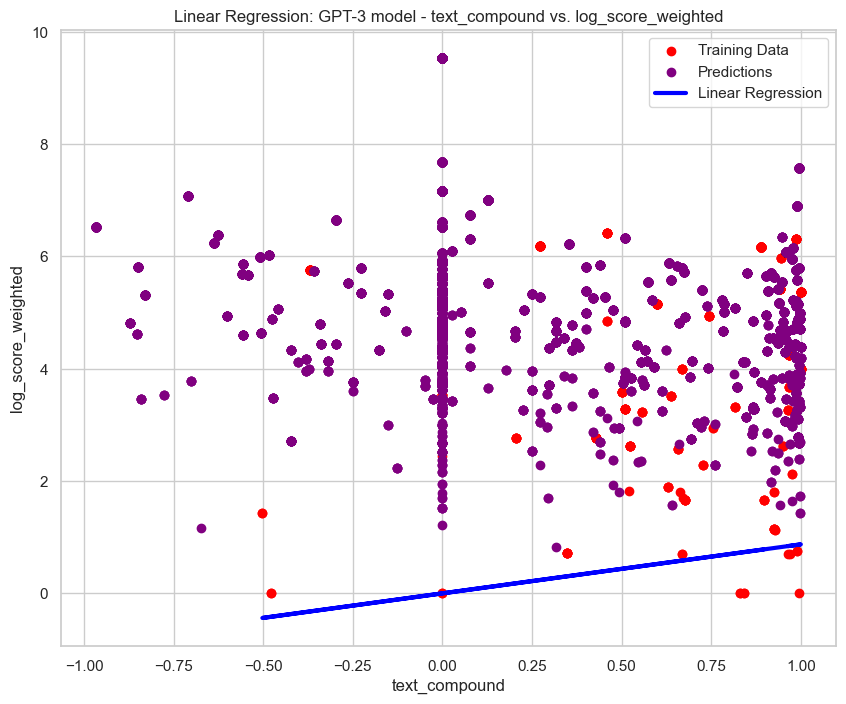

text_compound=0.8725537879331882


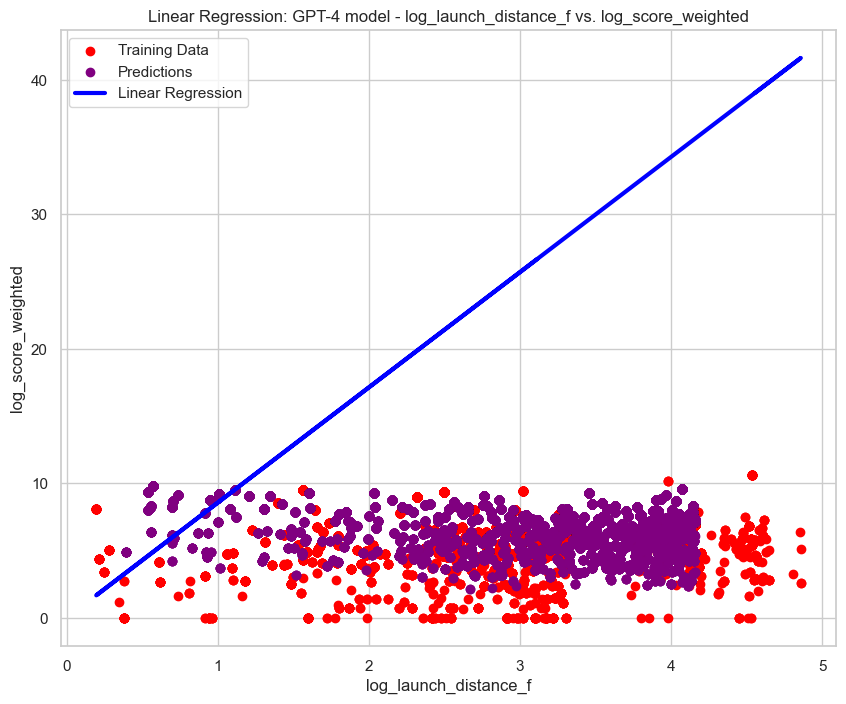

log_launch_distance_f=8.569101508248345


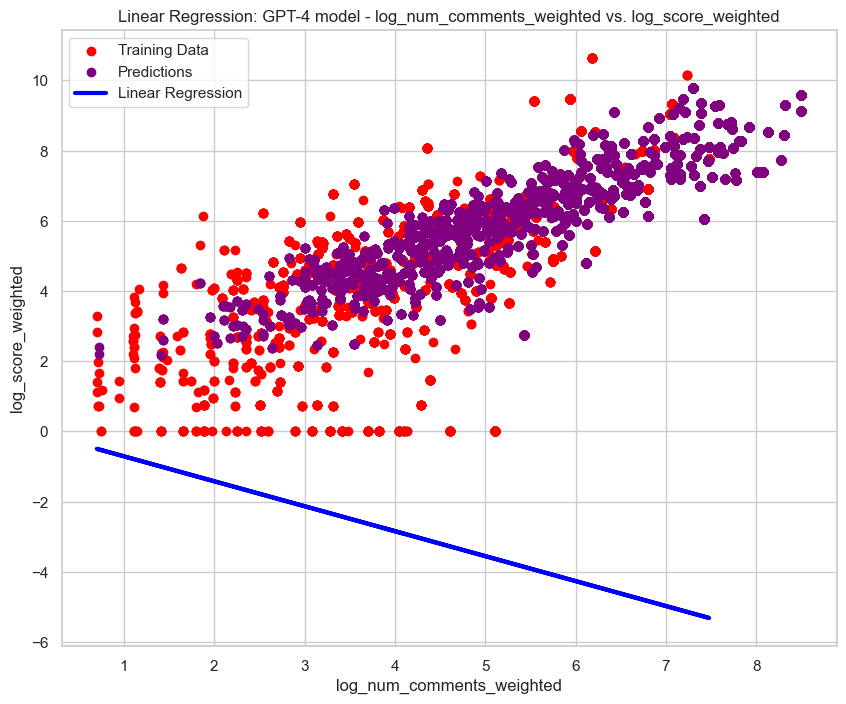

log_num_comments_weighted=-0.7108208888844165


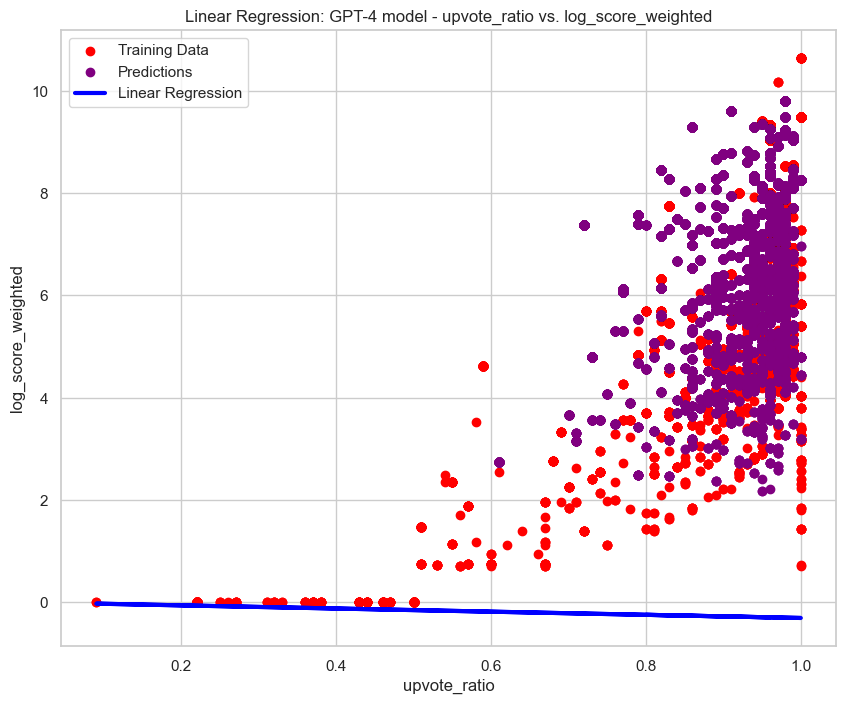

upvote_ratio=-0.30792515614119864


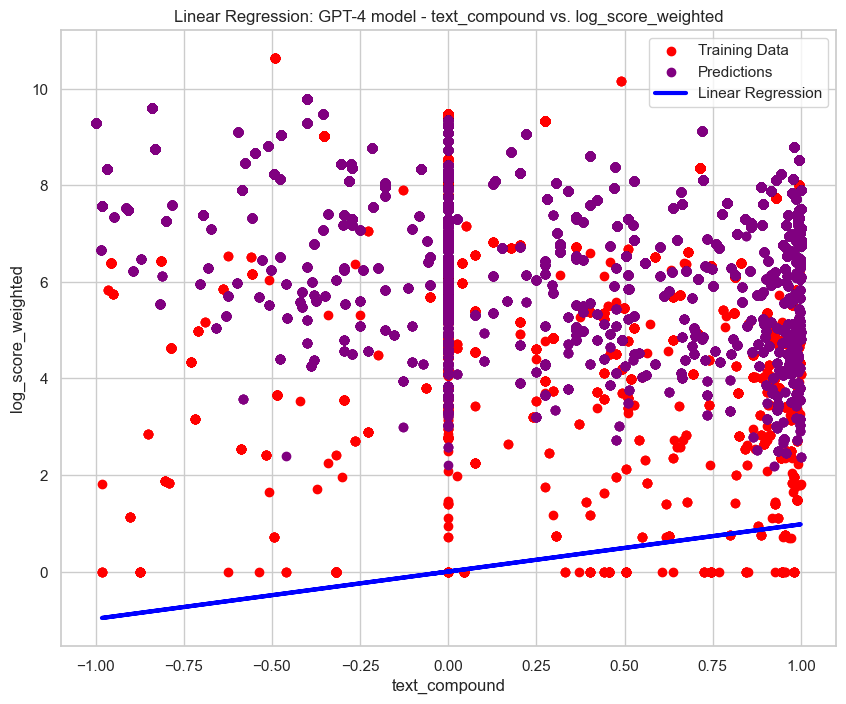

text_compound=0.9787754845870849


In [ ]:
def plot_features(model, name):
    for coef in feature_names:
        feature = coef
        plt.scatter(model['X'][feature], model['y'], color='red', label='Training Data')
        plt.scatter(model['X_test'][feature], model['y_pred'], color='purple', label='Predictions')
        y_fit = model['X'][feature] * model['coef'][0][feature_names.index(feature)]
        plt.plot(model['X'][feature], y_fit, color='blue', linewidth=3, label='Linear Regression')
        plt.xlabel(f"{feature}")
        plt.ylabel(f"{target_name}")
        plt.title(f"Linear Regression: {name} - {feature} vs. {target_name}")
        plt.legend()
        plt.show()
        print(f"{coef}={model['coef'][0][feature_names.index(coef)]}")
plot_features(model=gpt3_model, name='GPT-3 model')
plot_features(model=gpt4_model, name='GPT-4 model')

# Categorical Distributions

In [ ]:
def plot_distributions(dataset, name, category):
    # Count the occurrences of each category value
    category_counts = dataset[category].value_counts()

    # Plot the distribution as a bar chart
    plt.figure(figsize=(8, 6))
    ax = category_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {category} in {name}')
    plt.xlabel(category)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    ax.grid(False)  # Remove gridlines


    # Annotate each bar with its count
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')
        
    # Add total count outside the plot
    total_count = dataset[category].count()
    plt.text(1, 1, f'Total: {total_count}', ha='right', va='top', transform=ax.transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
for category in ['subreddit', 'query']:
    plot_distributions(dataset=df_gpt3_before, name='GPT-3 model before announcement', category=category)
    plot_distributions(dataset=df_gpt3_after, name='GPT-3 model after announcement', category=category)
    plot_distributions(dataset=df_gpt4_before, name='GPT-4 model before announcement', category=category)
    plot_distributions(dataset=df_gpt4_after, name='GPT-4 model after announcement', category=category)

KeyError: 'subreddit'

# Heatmap of MLflow runs

In [ ]:
# Fetch the data from MLflow
experiments = mlflow.search_runs()

# Convert 'start_time' column to datetime
experiments['start_time'] = pd.to_datetime(experiments['start_time'])
# Format 'start_time' to include date, hour, minute, and second
experiments['start_time'] = experiments['start_time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Trim the values in 'metrics.training_r2_score' to two decimal places
experiments['metrics.training_r2_score'] = experiments['metrics.training_r2_score'].apply(lambda x: round(x, 2))

# Sort by 'start_time' column in descending order
experiments_sorted = experiments.sort_values(by='start_time', ascending=False)

# Take every 4 experiments and collate them
experiments_sorted['start_time_grouped'] = experiments_sorted.groupby(experiments_sorted.index // 2)['start_time'].transform(lambda x: x.iloc[0])

# Take the most recent 5 experiments
num_experiments = 10
recent_experiments = experiments_sorted.head(num_experiments*2)

# Organize the data into a DataFrame
heatmap_data = recent_experiments.pivot_table(index='start_time_grouped', columns='metrics.training_r2_score', values='metrics.training_mean_squared_error')

# Sort the index in descending order
heatmap_data = heatmap_data.sort_index(ascending=False)

# Create the heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Heatmap of Mean Squared Error by Grouped Run Time and R2 Score')
plt.xlabel('Training R2 Score')
plt.ylabel('Run Time')
plt.show()